<a href="https://colab.research.google.com/github/AlexBB999/Classwork/blob/master/17_7_2_RF_DASK_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**THE ORIGINAL SUBMISSION IS BELOW THE--> XXXXXXXXXXXXXXXXXXXXXXXXXXXXX**



**THE DASK VERSION** 

**DASK XGB WITH BOOSTER='gbtree' -- BEST REULTS IN ALL METRICS**

In [1]:
!pip install --upgrade "dask[complete]"
!pip install dask-ml
!pip install -U ipykernel

     |████████████████████████████████| 808kB 2.8MB/s 
     |████████████████████████████████| 634kB 14.3MB/s 
     |████████████████████████████████| 102kB 9.2MB/s 
  Created wheel for locket: filename=locket-0.2.0-cp36-none-any.whl size=4040 sha256=8622fbeeb22a16bd69b7d3180fd52d3fc234900d5360572ab495d3c84aebd200
  Stored in directory: /root/.cache/pip/wheels/26/1e/e8/4fa236ec931b1a0cdd61578e20d4934d7bf188858723b84698
  Created wheel for contextvars: filename=contextvars-2.4-cp36-none-any.whl size=7666 sha256=b5f4ee8fa3b2e11cd37ee38e69612ae643985926451c27c1f771d00aea884a50
  Stored in directory: /root/.cache/pip/wheels/a5/7d/68/1ebae2668bda2228686e3c1cf16f2c2384cea6e9334ad5f6de
Successfully built locket contextvars
ERROR: distributed 2.16.0 has requirement tornado>=5; python_version < "3.8", but you'll have tornado 4.5.3 which is incompatible.
  Found existing installation: distributed 1.25.3
    Uninstalling distributed-1.25.3:
      Successfully uninstalled distributed-1.25.3
  Foun

     |████████████████████████████████| 122kB 2.8MB/s 
ERROR: google-colab 1.0.0 has requirement ipykernel~=4.10, but you'll have ipykernel 5.2.1 which is incompatible.
  Found existing installation: ipykernel 4.10.1
    Uninstalling ipykernel-4.10.1:
      Successfully uninstalled ipykernel-4.10.1


In [0]:
import joblib
import dask_ml.cluster
import dask.dataframe as dd
from dask_ml.model_selection import train_test_split
from dask_ml.linear_model import LogisticRegression

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
import joblib

In [3]:
import warnings
warnings.filterwarnings("ignore")

from dask.distributed import Client, progress

client = Client(n_workers=4, threads_per_worker=2, memory_limit='2GB')
client

Client Scheduler: tcp://127.0.0.1:33063 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 8.00 GB


In [0]:
from sklearn.linear_model import LogisticRegression
#from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets

from sklearn.datasets import load_breast_cancer
from sklearn.metrics import  classification_report, confusion_matrix
import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
from sklearn import tree

In [0]:
cancer =datasets.load_breast_cancer()

In [6]:
df = pd.DataFrame(np.c_[cancer['data'], cancer['target']], columns = np.append(cancer['feature_names'], ['target']))
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0.0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0.0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0.0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0.0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0.0


In [0]:
df= dd.from_pandas(df,npartitions=4)

In [0]:
X = df.drop('target',axis=1)
y = df['target']

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [60]:
X_test.compute().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113 entries, 19 to 568
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              113 non-null    float64
 1   mean texture             113 non-null    float64
 2   mean perimeter           113 non-null    float64
 3   mean area                113 non-null    float64
 4   mean smoothness          113 non-null    float64
 5   mean compactness         113 non-null    float64
 6   mean concavity           113 non-null    float64
 7   mean concave points      113 non-null    float64
 8   mean symmetry            113 non-null    float64
 9   mean fractal dimension   113 non-null    float64
 10  radius error             113 non-null    float64
 11  texture error            113 non-null    float64
 12  perimeter error          113 non-null    float64
 13  area error               113 non-null    float64
 14  smoothness error         

**USING PERSIST -- HAVE ROOM IN MEMORY**

In [61]:
X_train.persist()
X_test.persist()
y_train.persist()
y_test.persist()

Dask Series Structure:
npartitions=4
0      float64
143        ...
286        ...
429        ...
568        ...
Name: target, dtype: float64
Dask Name: split, 4 tasks

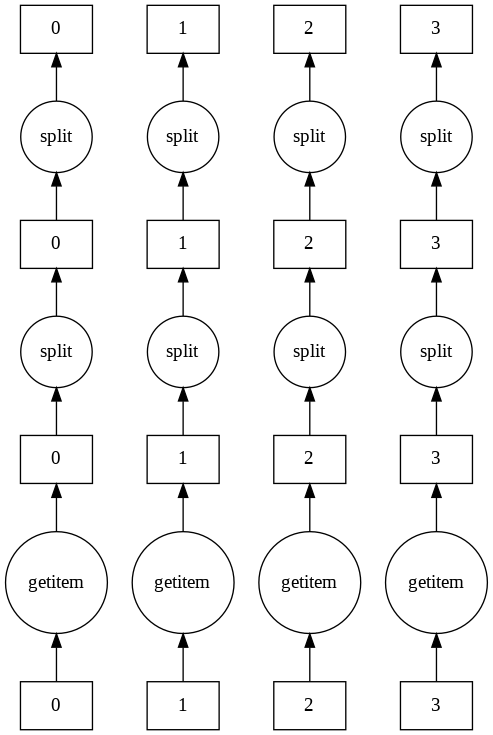

In [28]:
y_test.visualize()

In [12]:
rf_model = RandomForestClassifier()

with joblib.parallel_backend('dask'):
    scores = cross_validate(rf_model, X_train.compute(), y_train.compute(), cv=4)
    
scores

{'fit_time': array([3.59215641, 3.23972487, 3.10079169, 2.84271097]),
 'score_time': array([0.13684225, 0.12462854, 0.13845181, 0.10693049]),
 'test_score': array([0.94736842, 0.98245614, 0.97368421, 0.95614035])}

In [62]:
time_start = time.time()

rf_model.fit(X_train, y_train)
time.time()-time_start

0.37132978439331055

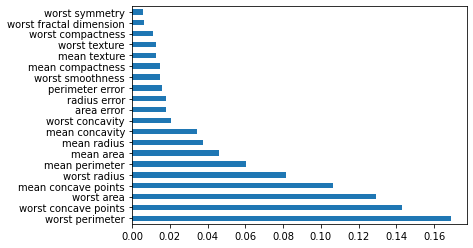

In [66]:
feat_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [0]:
# Random forest classifier
rf_params = {"max_depth": [2, 4, 8, 16]}

rf_model = RandomForestClassifier()

grid_search_rf = GridSearchCV(rf_model,
                           param_grid=rf_params,
                           return_train_score=True,
                           iid=True,
                           cv=4,
                           n_jobs=-1, 
                           scoring='roc_auc')

In [0]:
with joblib.parallel_backend('dask'):
    grid_search_rf.fit(X_train.compute(), y_train.compute())

In [15]:
print("The best value is: ", grid_search_rf.best_params_)
print("The test AUC score is: ", grid_search_rf.score(X_test.compute(), y_test.compute()))

The best value is:  {'max_depth': 16}
The test AUC score is:  0.9707207207207207


In [64]:
time_start = time.time()

grid_search_rf.fit(X_train.compute(), y_train.compute())
time.time()-time_start

4.325563430786133

In [45]:
cnf_matrix = confusion_matrix(y_test,grid_search_rf.predict(X_test))
cnf_matrix

array([[35,  4],
       [ 5, 69]])

In [67]:
precision=69/73
precision

0.9452054794520548

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

**ACCURACY WITH GRID_SEARCH_RF**

In [58]:
(grid_search_rf.predict(X_test)==y_test.compute()).sum()/len(y_test)

0.9203539823008849

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

**DASK DOES NOT HAVE A DECISION TREE PER-SE**

**SO I AM USING DASK XGBOOST WITH BOOSTER='gbtree'  --  THIS IS MOST SIMILAR**

In [0]:
import xgboost as xgb

In [0]:
model=xgb.XGBClassifier(objective='reg:squarederror',booster='gbtree')

In [22]:
model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='reg:squarederror', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [23]:
time_start = time.time()

model.fit(X_train, y_train)
time.time()-time_start

0.3581101894378662

In [24]:
with joblib.parallel_backend('dask'):
    scores = cross_validate(model, X_train.compute(), y_train.compute(), cv=4)
scores

{'fit_time': array([0.14895129, 0.22078943, 0.20364666, 0.234303  ]),
 'score_time': array([0.00341845, 0.00332785, 0.00322366, 0.00221729]),
 'test_score': array([0.93859649, 0.95614035, 0.96491228, 0.90350877])}

In [29]:
model.feature_importances_

array([7.6889299e-04, 1.1929552e-02, 2.5781814e-03, 5.9940903e-03,
       1.1441089e-02, 1.3875795e-03, 1.5495424e-03, 7.8648336e-02,
       1.8256787e-02, 1.1394165e-03, 2.6456681e-03, 4.7450271e-03,
       4.9597705e-03, 2.0447057e-02, 3.3643073e-03, 1.8859664e-03,
       6.1202614e-04, 2.6567688e-03, 5.0511729e-04, 3.2200892e-03,
       6.3746050e-02, 3.7830897e-02, 5.7615119e-01, 3.5274707e-02,
       1.0657254e-02, 5.0674103e-02, 1.7306518e-02, 2.7905863e-02,
       8.2701020e-04, 8.9118310e-04], dtype=float32)

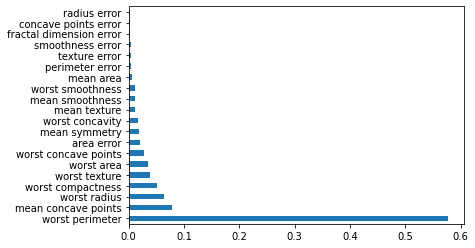

In [35]:
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

**ACCURACY SCORE WITH DASK XGBOOST**

In [0]:
pred=model.predict(X_test)

In [27]:
(pred==y_test.compute()).sum()/len(pred)

0.9469026548672567

In [44]:
cnf_matrix = confusion_matrix(y_test, pred)
cnf_matrix

array([[36,  3],
       [ 3, 71]])

In [68]:
precision2=71/74
precision2

0.9594594594594594

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

**RANDOM FOREST**

In [0]:
bc_rf_clf = RandomForestClassifier()

In [0]:
time_start = time.time()

bc_rf_clf.fit(breast_cancer_X_train, breast_cancer_y_train)
time.time()-time_start

0.19361138343811035

In [0]:
bc_predictions = bc_rf_clf.predict(breast_cancer_X_test)
bc_report = classification_report(breast_cancer_y_test, bc_predictions)
print(bc_report)

              precision    recall  f1-score   support

           0       0.94      0.89      0.91        53
           1       0.94      0.97      0.95        90

    accuracy                           0.94       143
   macro avg       0.94      0.93      0.93       143
weighted avg       0.94      0.94      0.94       143



**DECISION TREE**

In [0]:
decision_tree = tree.DecisionTreeClassifier()

In [0]:
time_start = time.time()

decision_tree.fit(breast_cancer_X_train, breast_cancer_y_train)
time.time()-time_start

0.011156320571899414

In [0]:
dt_predictions = decision_tree.predict(breast_cancer_X_test)
dt_report = classification_report(breast_cancer_y_test, dt_predictions)
print(dt_report)

              precision    recall  f1-score   support

           0       0.90      0.83      0.86        53
           1       0.90      0.94      0.92        90

    accuracy                           0.90       143
   macro avg       0.90      0.89      0.89       143
weighted avg       0.90      0.90      0.90       143



**DECISION TREE IS FASTER BUT  NOT AS ACCURATE**